In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
from munkres import Munkres
from scipy.io import loadmat

In [2]:
# Please modify working_dir if required
Working_directory="./"


x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')

X = data


def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None,cmap='gray'):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=int(np.ceil(len(indeces)/ncol))
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap=cmap)
        plt.xticks(())
        plt.yticks(())

There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


In [3]:
def multiplicativeUpdate(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1, W=None):
    '''
    Inputs: 
    %           X: is a [dxN] matrix. Every column (x) is an observation and every
    %           row consists of features.
    %
    %           r: size of the matrices W and H
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           W: is a [d x r] matrix containing the basis images in its
    %           columns
    %           
    %           H: is a [r x N] matrix containing the loadings (h) in its columns
    %           of the linear combination: x=Wh 
    %
  '''
    if r is None:
        r=X.shape[0]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    if W is None:
        W = np.random.rand(d, r)
    H = np.random.rand(r, N)
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # Multiplicative method      
        W = np.maximum(eps, W * (X @ H.T) / (W @ H @ H.T))
        H = np.maximum(eps, H * (W.T @ X) / (W.T @ W @ H))
        
        
        # Convergence indices
        k = k + 1           
        diff=X-np.dot(W,H)     

        delta = np.linalg.norm(diff,'fro') / np.linalg.norm(X,'fro') 
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration NNMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', np.linalg.norm(diff))
     
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
    
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NNMF')
        plt.show()
    
    return W,H

Iteration NNMF number  1  out of  400 , delta =  0.5365044702443005 , error (norm delta):  309.3615073443595
Iteration NNMF number  100  out of  400 , delta =  0.1913986950151575 , error (norm delta):  110.36513594503734
Iteration NNMF number  200  out of  400 , delta =  0.16703370729349104 , error (norm delta):  96.31569228510054
Iteration NNMF number  300  out of  400 , delta =  0.15978192978275504 , error (norm delta):  92.13414125230922
Iteration NNMF number  400  out of  400 , delta =  0.15636486795371882 , error (norm delta):  90.16378041330603
Maximum number of iterations reached ! delta =  0.15636486795371882


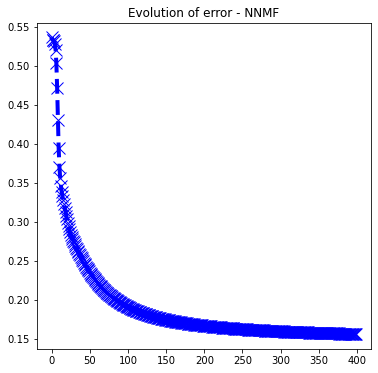

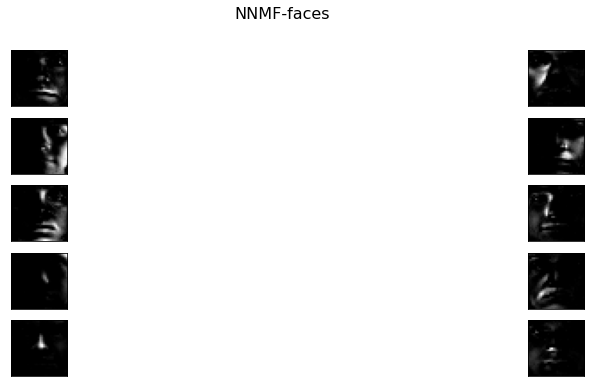

In [4]:
# Launch the MU algorithm
Ncomponents=100
A_tot,S_tot = multiplicativeUpdate(X.T,r=Ncomponents,N_Iter=400,tolerance=1e-3,plot_evolution=1)
plotFaces(A_tot.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

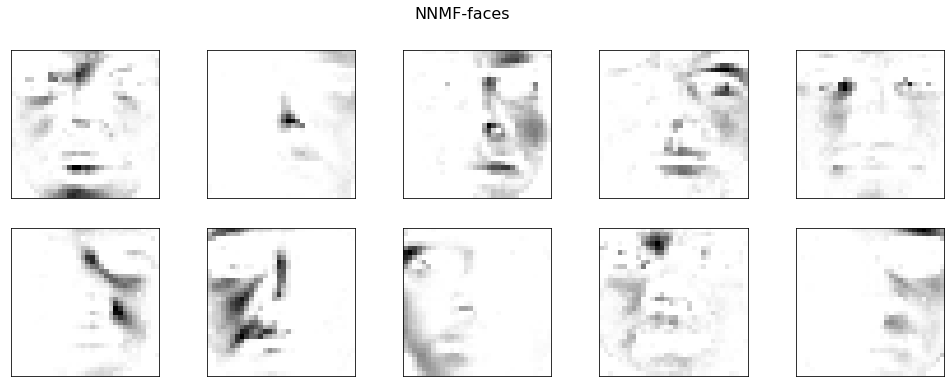

In [15]:
shift = 0
plotFaces(A_tot.T,r,c,ncol=5,indeces=np.arange(shift,shift+10,1),title='NNMF-faces', cmap="gray_r") 

In [7]:
#### MODEL PARAMS #####
var_x = 0.0001 # 0.1
nb_features = 15
A = A_tot[:,:nb_features]
Cinv = (A.T @ A) / (1-var_x)
C = np.linalg.inv(Cinv) # prior covariance (which is fitted to whitened data)
print(A.shape, C.shape)

##### INTEGRATION PARAMS ######
tau = 0.01 # 0.01
tau_l = 2 / 13 # 2/13
dt = 0.001

B = np.eye(len(C))
M = np.maximum(0, C / (1-var_x))
# M = B.copy()
Wu = np.empty((4, *C.shape))
Wu[0] = B.T @ M @ B - tau/tau_l * M @ B
# Wu[0] = B/2
Wu[1] = B.T @ M - tau/tau_l * M
# Wu[1] = np.zeros_like(M)
Wu[2] = M @ B + tau/tau_l * B.T @ M @ B
# Wu[2] = np.zeros_like(M)
Wu[3] = M + tau/tau_l * B.T @ M
# Wu[3] = B/2

Wz = np.empty(4)
Wz[0] = 1 - tau/tau_l
# Wz[0] = 1/2
Wz[1] = 1 - tau/tau_l
# Wz[1] = 0
Wz[2] = 1 + tau/tau_l
# Wz[2] = 0
Wz[3] = 1 + tau/tau_l
# Wz[3] = 1/2
Wall = [Wu, Wz]

(1024, 15) (15, 15)


In [8]:
def forward_sample(n_samples):
    u = np.random.multivariate_normal(np.zeros(len(C)), C, n_samples)
    z = np.random.randn(n_samples)
    # z[z<0] = np.zeros_like(z[z<0])
    # z = np.ones(n_samples)
    z = np.abs(z)
    mean = z * (A @ u.T)
    x = (var_x**0.5 * np.random.randn(*mean.shape) + mean).T
    print(x.shape, u.shape, z.shape)
    return x, u ,z

In [9]:
def I_input(a, c, x, for_z=False):
    if for_z:
        u, z = c, a
        return var_x * (1/var_x * (A @ u).T @ (x - z * A @ u) - z)
    else:
        u, z = a, c
        return var_x * (z/var_x * A.T @ (x- z* (A @ u)) - Cinv @ u)

def F(a, b, c, x, for_z=False):
    I = 0.1*I_input(a, c, x, for_z=for_z)
    excitatory = np.dot(Wall[for_z][0], a) - np.dot(Wall[for_z][1], b)
    inhibitory = np.dot(Wall[for_z][2], a) - np.dot(Wall[for_z][3], b)
    delta_a = (excitatory + tau/tau_l * I) / tau
    delta_b = (inhibitory - I) / tau
    return delta_a, delta_b, excitatory, inhibitory

def forward(a, b, c, x, for_z=False, Langevin=False):
    leng = for_z + (1-for_z)*len(u)
    noise = np.sqrt(2/tau_l) * np.random.randn(2*leng)
    if Langevin:
        delta_a = I_input(a, c, x, for_z=for_z) / tau_l
        new_b, excitatory, inhibitory = None, 0, 0
    else:
        delta_a, delta_b, excitatory, inhibitory = F(a, b, c, x, for_z=for_z)
        new_b = b + dt*(delta_b + noise[leng:])
    new_a = a + dt*(delta_a + noise[:leng])
    return new_a, new_b, excitatory, inhibitory

(15, 1024) (15, 15) (15,)


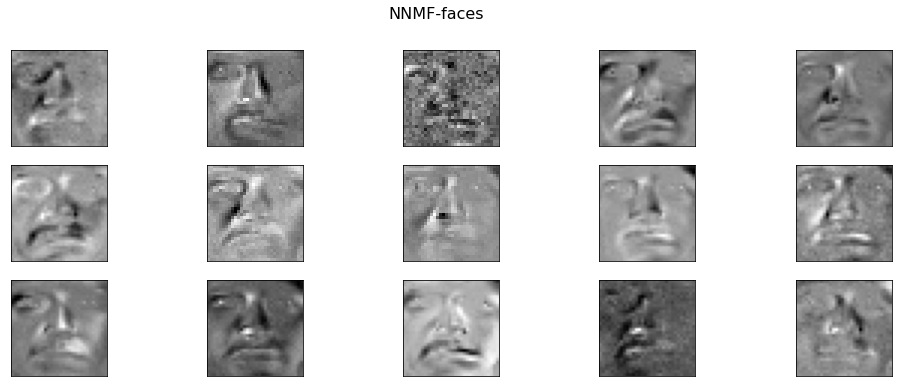

In [10]:
n_samples = 15
xs, us_true, zs_true = forward_sample(n_samples)
plotFaces(xs,r,c,ncol=5,indeces=np.arange(0,n_samples,1),title='NNMF-faces') 

In [11]:
n_samples = 15
n_steps = 1000

_, us, zs = forward_sample(n_samples)
# _, us, zs = _, us_true, zs_true
zs = 0.001*np.ones(n_samples)
vs = us @ B.T + np.random.multivariate_normal(np.zeros(len(C)), np.linalg.inv(M), n_samples)
nus = zs + np.random.randn(n_samples)   

(15, 1024) (15, 15) (15,)


In [12]:
Langevins = [False, True]
Langevins = [False]
indices = [3,11]
trajss = []
for Langevin in Langevins:
    trajs = []
    trues = []
    exc_inhs_u, exc_inhs_z = [], []
    for i in indices:
        x, u_true, z_true = xs[i], us_true[i], zs_true[i]
        trues.append([u_true, z_true])
        u, v, z, nu = us[i], vs[i], zs[i], nus[i]
        traj = [[u, v, [z], [nu]]]
        exc_inh_u, exc_inh_z = [], []
        for step in range(n_steps):
            u, v, exc_u, inh_u = forward(u, v, z, x, for_z=False, Langevin=Langevin)
            z, nu, exc_z, inh_z = forward(z, nu, u, x, for_z=True, Langevin=Langevin)
            z  = np.abs(z)
            traj.append([u, v, z, nu])
            exc_inh_u.append([exc_u, inh_u])
            exc_inh_z.append([exc_z, inh_z])
            if step == n_steps//3:
                x = xs[1-i]
            if step == 2*n_steps//3:
                x = xs[i]
            
        trajs.append(traj)
        exc_inhs_u.append(exc_inh_u)
        exc_inhs_z.append(exc_inh_z)
    trajss.append(trajs)

In [ ]:
u_trajss = np.array([[[u for u, v, z, nu in traj] for traj in trajs] for trajs in trajss])
z_trajss = np.array([[[z for u, v, z, nu in traj] for traj in trajs] for trajs in trajss])
titles = ["no-stimulus", "stimulus"]
titles = ["onset", "offset"]
plt.figure(figsize=(10,7))
for i in range(len(u_trajss[0])):
    dim1, dim2 = 0, 1
    plt.subplot(len(u_trajss[0]),2,2*i+1)
    plt.scatter(trues[i][0][dim1], trues[i][0][dim2], color='r', marker='+',label="true u")
    
    l = 0
    plt.plot(u_trajss[l,i,:,dim1], u_trajss[l,i,:,dim2], label="Langevin" if Langevins[l] else "HMC");
    plt.scatter(u_trajss[l,i,-1,dim1], u_trajss[l,i,-1,dim2], color='b', marker='+')
    plt.scatter(u_trajss[l,i,0,dim1], u_trajss[l,i,0,dim2], color='b', marker='o')
    l = 1
    plt.plot(u_trajss[l,i,:,dim1], u_trajss[l,i,:,dim2], label="Langevin" if Langevins[l] else "HMC");
    plt.scatter(u_trajss[l,i,-1,dim1], u_trajss[l,i,-1,dim2], color='C1', marker='+')
    plt.scatter(u_trajss[l,i,0,dim1], u_trajss[l,i,0,dim2], color='C1', marker='o')
    
    plt.title("u under "+titles[i])
    plt.legend()
    
    plt.subplot(len(u_trajss[0]),2,2*i+2)
    plt.hlines(trues[i][1], 0, len(z_trajss[0,i]), color='r', label="true z")
    
    l = 0
    plt.plot(z_trajss[l,i], label="Langevin" if Langevins[l] else "HMC");
    l = 1
    plt.plot(z_trajss[1,i], label="Langevin" if Langevins[l] else "HMC");
    
    plt.title("z under "+titles[i])
    plt.legend()
plt.tight_layout()

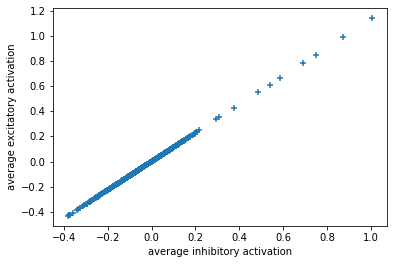

In [27]:
tmp = np.array(np.array(exc_inhs_u, dtype=object)[:,1:,:,3])
kplt = 1
plt.figure(figsize=(7,5))
plt.scatter(tmp[kplt,:,0], tmp[kplt,:,1], marker='+');
plt.ylabel("average excitatory activation")
plt.xlabel("average inhibitory activation");

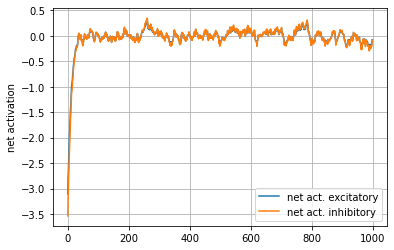

In [25]:
plt.figure(figsize=(7,5))
plt.plot(tmp[kplt,:,0], label="net act. excitatory")
plt.plot(tmp[kplt,:,1], label="net act. inhibitory")
plt.ylabel("net activation")
plt.grid(),plt.legend();

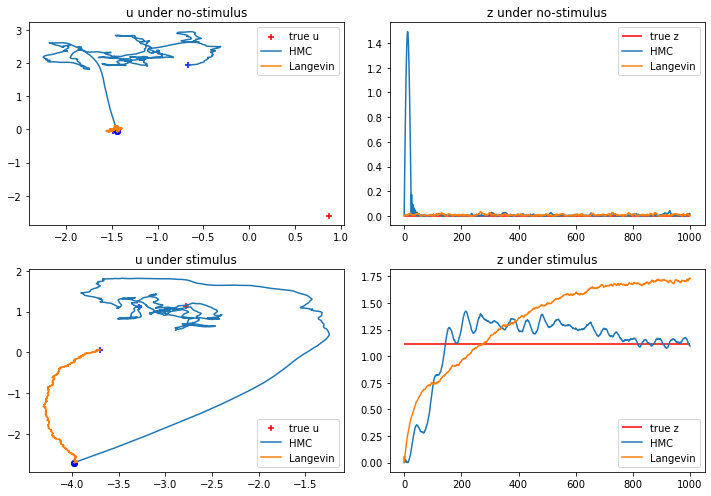

In [54]:
u_trajss = np.array([[[u for u, v, z, nu in traj] for traj in trajs] for trajs in trajss])
z_trajss = np.array([[[z for u, v, z, nu in traj] for traj in trajs] for trajs in trajss])
titles = ["no-stimulus", "stimulus"]
plt.figure(figsize=(10,7))
for i in range(len(u_trajss[0])):
    dim1, dim2 = 0, 1
    plt.subplot(len(u_trajss[0]),2,2*i+1)
    plt.scatter(trues[i][0][dim1], trues[i][0][dim2], color='r', marker='+',label="true u")
    
    l = 0
    plt.plot(u_trajss[l,i,:,dim1], u_trajss[l,i,:,dim2], label="Langevin" if Langevins[l] else "HMC");
    plt.scatter(u_trajss[l,i,-1,dim1], u_trajss[l,i,-1,dim2], color='b', marker='+')
    plt.scatter(u_trajss[l,i,0,dim1], u_trajss[l,i,0,dim2], color='b', marker='o')
    l = 1
    plt.plot(u_trajss[l,i,:,dim1], u_trajss[l,i,:,dim2], label="Langevin" if Langevins[l] else "HMC");
    plt.scatter(u_trajss[l,i,-1,dim1], u_trajss[l,i,-1,dim2], color='b', marker='+')
    plt.scatter(u_trajss[l,i,0,dim1], u_trajss[l,i,0,dim2], color='b', marker='o')
    
    plt.title("u under "+titles[i])
    plt.legend()
    
    plt.subplot(len(u_trajss[0]),2,2*i+2)
    plt.hlines(trues[i][1], 0, len(z_trajss[0,i]), color='r', label="true z")
    
    l = 0
    plt.plot(z_trajss[l,i], label="Langevin" if Langevins[l] else "HMC");
    l = 1
    plt.plot(z_trajss[1,i], label="Langevin" if Langevins[l] else "HMC");
    
    plt.title("z under "+titles[i])
    plt.legend()
plt.tight_layout()

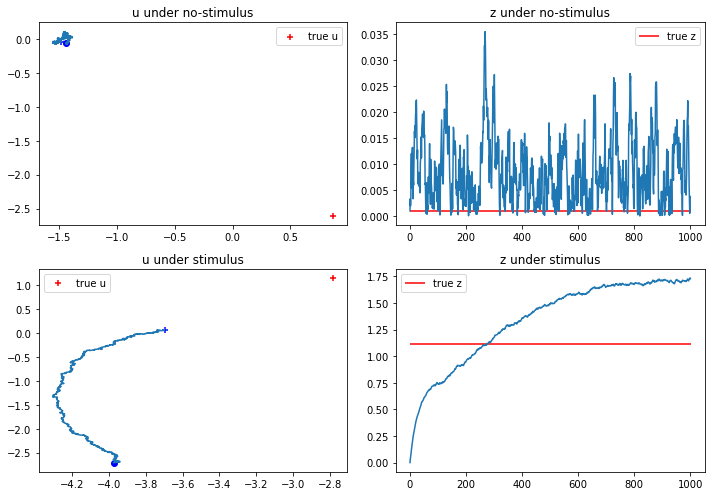

In [45]:
u_trajs = np.array([[u for u, v, z, nu in traj] for traj in trajs])
z_trajs = np.array([[z for u, v, z, nu in traj] for traj in trajs])
titles = ["no-stimulus", "stimulus"]
plt.figure(figsize=(10,7))
for i in range(len(u_trajs)):
    dim1, dim2 = 0, 1
    plt.subplot(len(u_trajs),2,2*i+1)
    plt.plot(u_trajs[i,:,dim1], u_trajs[i,:,dim2]);
    plt.scatter(trues[i][0][dim1], trues[i][0][dim2], color='r', marker='+',label="true u")
    plt.scatter(u_trajs[i,-1,dim1], u_trajs[i,-1,dim2], color='b', marker='+')
    plt.scatter(u_trajs[i,0,dim1], u_trajs[i,0,dim2], color='b', marker='o')
    plt.title("u under "+titles[i])
    plt.legend()
    
    plt.subplot(len(u_trajs),2,2*i+2)
    plt.hlines(trues[i][1], 0, len(z_trajs[i]), color='r', label="true z")
    plt.title("z under "+titles[i])
    plt.plot(z_trajs[i]);
    plt.legend()
plt.tight_layout()

(5, 1024)
(5, 1024)


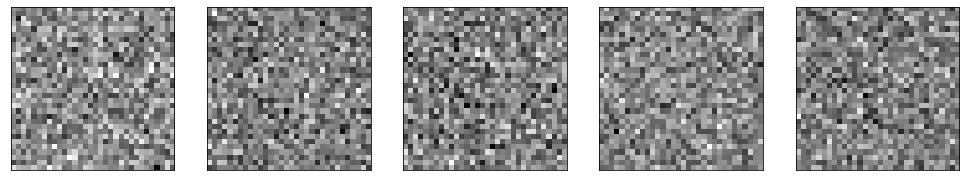

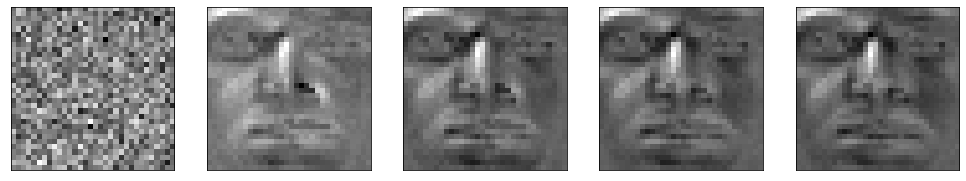

In [71]:
# RECONSTRUCTION
stepplotted = np.arange(0,len(u_trajs[0]), len(u_trajs[0])//4)//1
us_final, zs_final = u_trajs[:,stepplotted], z_trajs[:,stepplotted]
for i in range(len(us_final)):
    mean_final = (np.abs(zs_final[i])*(A @ us_final[i].T).T)
    print(mean_final.shape)
    x_final = (var_x**0.5 * np.random.randn(*mean_final.shape) + mean_final)
    plotFaces(x_final,r,c,ncol=5,indeces=range(len(x_final)), title=None, cmap='gray') 